In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import sys
sys.path.insert(0, '../')
from utils import *
import sigpy as sp
import sigpy.mri as mr
import cv2

In [2]:
preprocess = lambda x : x / 127 - 1
deprocess  = lambda x :((x + 1) * 127).astype(np.uint8)

def get_image_normalized(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.expand_dims(-1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv))), 2)
    if plot:
        plt.imshow(normalized_img[:, :, 0], cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img


def get_subsampled_normalized(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask)).astype(float)
    minv = np.min(new_img)
    maxv = np.max(new_img)
    normalized_new_img = np.expand_dims(-1 + (2 * (new_img - minv) / (maxv - minv)), 2)
    if plot:
        plt.imshow(normalized_new_img[:, :, 0], cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img
def get_best_L2(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.square(img[:, :, 0] - compare[:, :, 0]))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_best_L1(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.abs(img[:, :, 0] - compare[:, :, 0]))
        #print(mse)
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_best_L1_2chan(all_ims, compare):
    compare = np.sqrt(compare[:, :, 0] ** 2 + compare[:, :, 1] ** 2)
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        img = np.sqrt(img[:, :, 0] ** 2 + img[:, :, 1] ** 2)
        mse = np.mean(np.abs(img - compare))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_wavelet_recon(subs, lamda=0.001): 
    img = subs[:, :, 0].astype(np.complex)
    ksp = sp.fft.fft(img)
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    return np.real(img_l1wav)

def get_wavelet_recon_2chan(subs, lamda=0.001): 
    img = (subs[:, :, 0] + 1j*subs[:, :, 1]).astype(np.complex)
    ksp = sp.fft.fft(img)
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    return np.sqrt(np.real(img_l1wav)**2 + np.imag(img_l1wav)**2)

def get_image_normalized_2chan(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.zeros((320, 256, 2))
    normalized_img_real = -1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv)))
    normalized_img[:, :, 0] = normalized_img_real
    normalized_img[:, :, 1] = img[:, :, 1]
    if plot:
        plt.imshow(np.sqrt(normalized_img[:, :, 0] ** 2 + normalized_img[:, :, 1] ** 2), cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img

def get_batch_normalized_2chan(indices):
    return np.array([get_image_normalized_2chan(ind) for ind in indices])


def get_subsampled_normalized_2chan(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask))
    minv = np.min(np.real(new_img))
    maxv = np.max(np.real(new_img))
    normalized_new_img = np.zeros((320, 256, 2))
    normalized_new_img_real = -1 + (2 * (np.real(new_img) - minv) / (maxv - minv))
    normalized_new_img[:, :, 0] = normalized_new_img_real
    normalized_new_img[:, :, 1] = np.imag(new_img) 
    if plot:
        plt.imshow(np.sqrt(normalized_new_img[:, :, 0] ** 2 + normalized_new_img[:, :, 1] ** 2), cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img
def get_brain_normalized():
    image = cv2.imread('brain.png')
    return preprocess(image)[:, :, 0:1]

Reconstructions on subsampled x4:
Trial 0


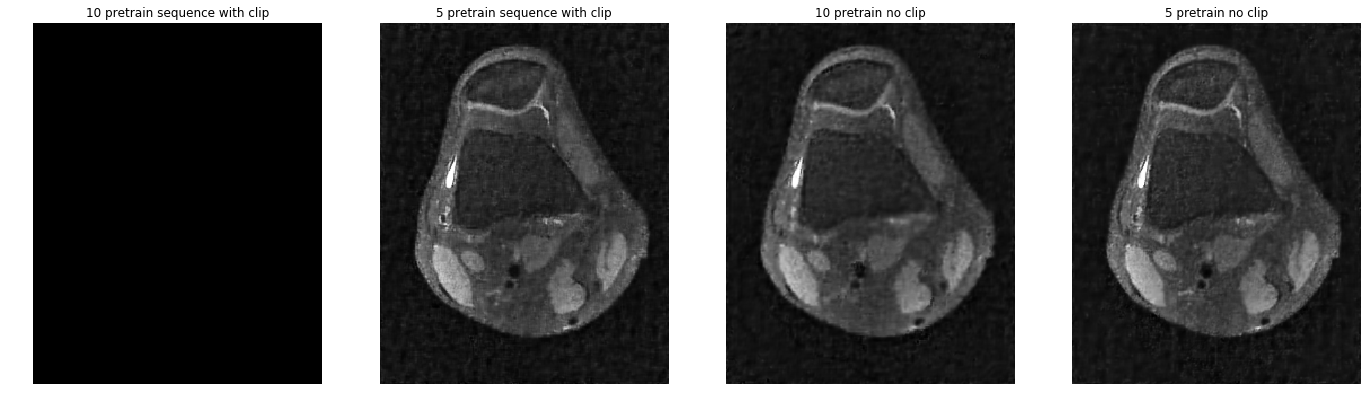

L1 errors:  [0.26781041050593435, 0.08961489479025878, 0.08745709282508825, 0.08797593502484823]
L2 errors:  [0.1084305370681026, 0.01435549749564117, 0.013860262986545102, 0.013981423991524092]
Trial 1


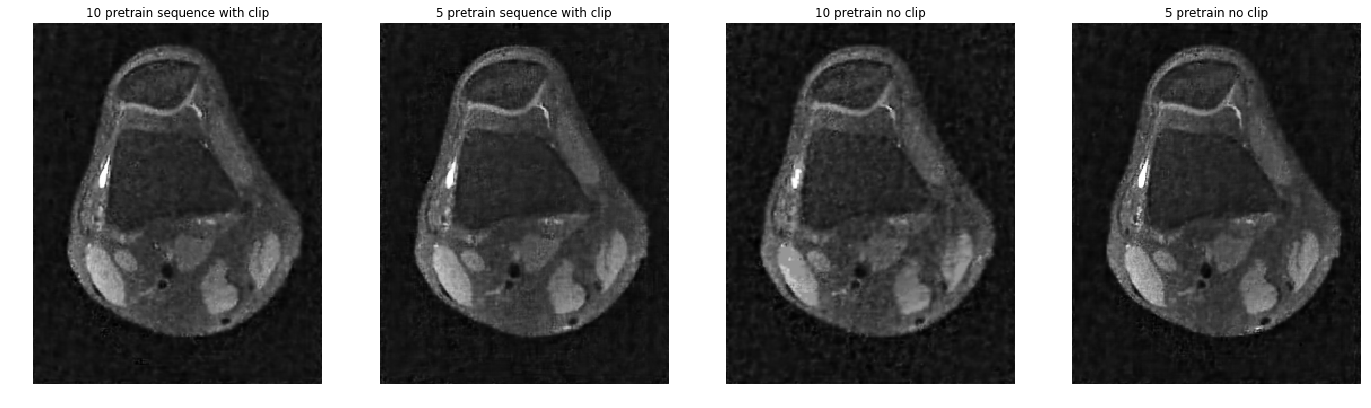

L1 errors:  [0.0873773080181571, 0.08788391893755179, 0.09082660686472181, 0.08854673930500581]
L2 errors:  [0.013871594525672905, 0.013983898787178933, 0.015156633651982592, 0.014036230076480092]
Trial 2


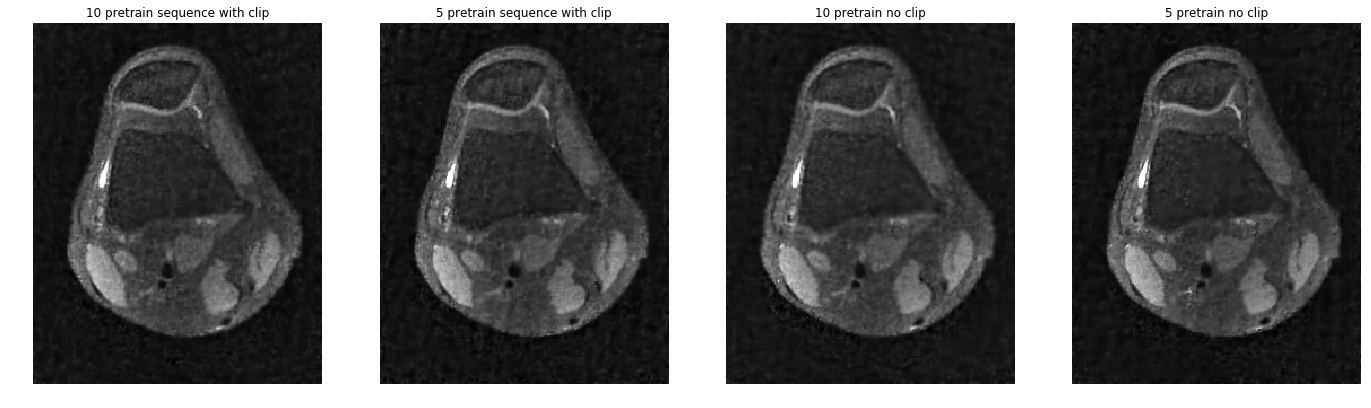

L1 errors:  [0.08763616865446577, 0.09005107424978942, 0.08799059968917007, 0.08789456752622596]
L2 errors:  [0.014129061781123617, 0.014587611303193106, 0.01414770670236098, 0.013941693560675057]


In [5]:
# compare init img1->...->img10 vs img5->...->img10 with clipping grad at 1 vs no clipping
# used unet with 3 skip connection layers
# feed in different noise (gaussian noise) for each pretrain image/test (same across diff inits)
# 70x20 train init and recon iterations at 1e-3 learning rate with jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(70, plot=False)
diff_img2 = get_image_normalized(170, plot=False)
diff_img3 = get_image_normalized(240, plot=False)


all_results = np.load('../deep_prior_data/sequential_train/sequential_gradient_clip_L1.npy')
trials = 3
titles = ['10 pretrain sequence with clip', '5 pretrain sequence with clip', '10 pretrain no clip', '5 pretrain no clip']
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(4): 
        curr = all_results[j][i]
        #best, ind = get_best_L1(curr[0], orig_img)
        best, ind = curr[0][-1], -1
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

Reconstructions on subsampled x4:
Trial 0


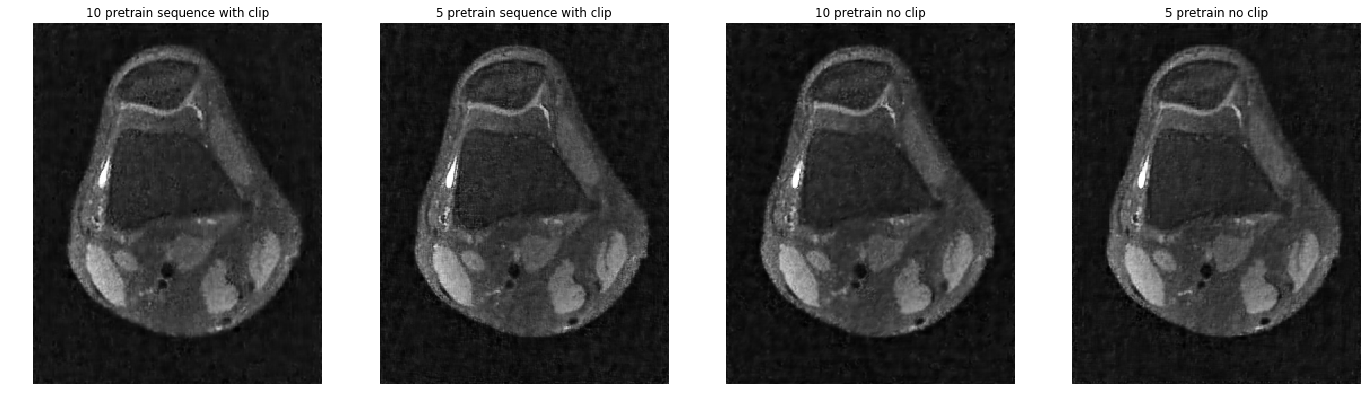

L1 errors:  [0.0876928158543968, 0.08929389373524302, 0.08849888294740206, 0.08911317506998424]
L2 errors:  [0.014053143117922101, 0.014203716697906788, 0.014252740006062196, 0.014249687781389195]


In [6]:
# compare init img1->...->img10 vs img5->...->img10 with clipping grad at 0.1 vs no clipping
# different masks used when pretraining
# used unet with 3 skip connection layers
# feed in different noise (gaussian noise) for each pretrain image/test (same across diff inits)
# 70x20 train init and recon iterations at 1e-3 learning rate with jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(70, plot=False)
diff_img2 = get_image_normalized(170, plot=False)
diff_img3 = get_image_normalized(240, plot=False)


all_results = np.load('../deep_prior_data/sequential_train/sequential_reconpretrain_gradient_moreclip_L1.npy')
trials = 1
titles = ['10 pretrain sequence with clip', '5 pretrain sequence with clip', '10 pretrain no clip', '5 pretrain no clip']
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(4): 
        curr = all_results[j][i]
        #best, ind = get_best_L1(curr[0], orig_img)
        best, ind = curr[0][-1], -1
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

Reconstructions on subsampled x4:
Trial 0


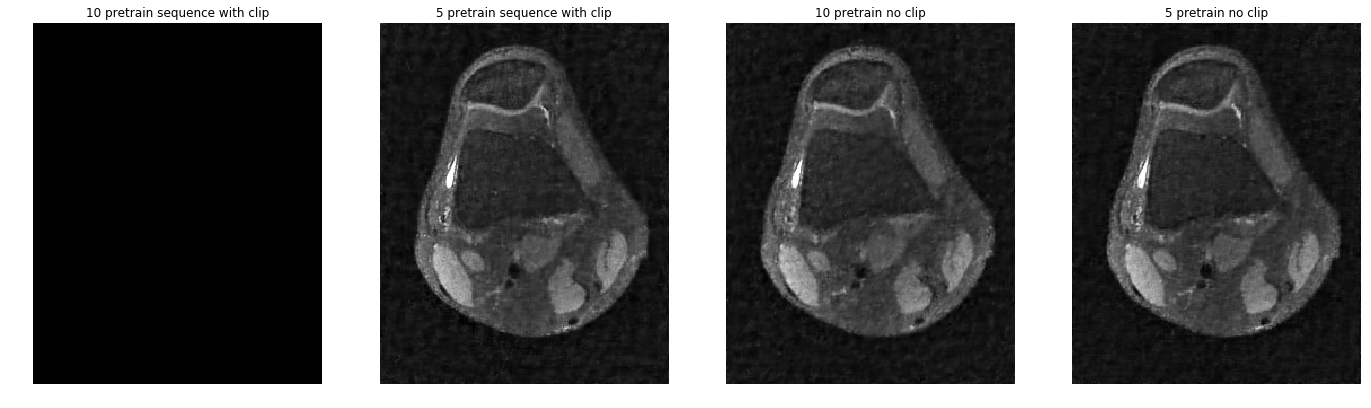

L1 errors:  [0.26781041050593435, 0.08906515875777737, 0.09017806591692143, 0.08865251602689925]
L2 errors:  [0.1084305370681026, 0.014139439969030842, 0.014677031157577018, 0.014078556160892514]


In [7]:
# compare init img1->...->img10 vs img5->...->img10 with clipping grad at 0.1 vs no clipping
# same mask used when pretraining
# used unet with 3 skip connection layers
# feed in different noise (gaussian noise) for each pretrain image/test (same across diff inits)
# 70x20 train init and recon iterations at 1e-3 learning rate with jittering


orig_img = get_image_normalized(100, plot=False)
diff_img1 = get_image_normalized(70, plot=False)
diff_img2 = get_image_normalized(170, plot=False)
diff_img3 = get_image_normalized(240, plot=False)


all_results = np.load('../deep_prior_data/sequential_train/sequential_same_reconpretrain_gradient_moreclip_L1.npy')
trials = 1
titles = ['10 pretrain sequence with clip', '5 pretrain sequence with clip', '10 pretrain no clip', '5 pretrain no clip']
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(4): 
        curr = all_results[j][i]
        #best, ind = get_best_L1(curr[0], orig_img)
        best, ind = curr[0][-1], -1
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)